In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 'relevantdata.csv' was the cleaned dataset containing all relevant data, saved after Step 3 of the data cleaning code
data = pd.read_csv('relevantdata.csv')
# create month-year labels
data['monthyear'] = data['year'].astype(str) + data['Month'].astype(str).str.zfill(2)

In [3]:
print(data.columns)

Index(['cusip', 'RET', 'year', 'Month', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',
       'RF', 'ExcessReturn', 'comname', 'sector',
       'AnalyticCO2EstimationMethod',
       'AnalyticEstimatesCO2EquivalentsEmissionTotal', 'TotalAssets',
       'monthyear'],
      dtype='object')


# Sector and Estimation Method Cleaning + Analysis

In [4]:
# Printing the percentages of the total dataset belonging to each sector
counts = data['sector'].value_counts().to_frame()
# Reset the index to make the unique values a column
counts.reset_index(inplace=True)
# Rename the columns
counts.columns = ['Sector', 'Count']
total = counts['Count'].sum()
counts['Percentage'] = counts['Count']/total
print(counts)

                Sector   Count  Percentage
0        Manufacturing  114715    0.316165
1       DidNotIdentify   64887    0.178834
2           FinanceIns   54071    0.149024
3             Services   31736    0.087467
4           RealEstate   20190    0.055645
5               OilGas   14068    0.038773
6            Utilities   12234    0.033718
7            Wholesale   10121    0.027894
8   TransportWarehouse    9720    0.026789
9            AccomFood    8188    0.022567
10        Construction    5962    0.016432
11          Healthcare    5892    0.016239
12         Information    5227    0.014406
13              Retail    3705    0.010211
14          ArtsEntRec    1409    0.003883
15         Agriculture     552    0.001521
16          Management     156    0.000430


In [5]:
# Drop rows where column 'sector' is equal to 'DidNotIdentify' (can't make assumptions if we don't know the sector)
data = data[data['sector'] != 'DidNotIdentify']

# Drop sectors that comprise of less than 1% of the total dataset
data = data[data['sector'] != 'Management']
data = data[data['sector'] != 'Agriculture']
data = data[data['sector'] != 'ArtsEntRec']

In [6]:
# Re-printing the percentages of the total dataset belonging to each sector after removing the sectors above
counts = data['sector'].value_counts().to_frame()
# Reset the index to make the unique values a column
counts.reset_index(inplace=True)
# Rename the columns
counts.columns = ['Sector', 'Count']
total = counts['Count'].sum()
counts['Percentage'] = counts['Count']/total
print(counts)

                Sector   Count  Percentage
0        Manufacturing  114715    0.387775
1           FinanceIns   54071    0.182778
2             Services   31736    0.107278
3           RealEstate   20190    0.068249
4               OilGas   14068    0.047554
5            Utilities   12234    0.041355
6            Wholesale   10121    0.034212
7   TransportWarehouse    9720    0.032857
8            AccomFood    8188    0.027678
9         Construction    5962    0.020154
10          Healthcare    5892    0.019917
11         Information    5227    0.017669
12              Retail    3705    0.012524


Analyzing the breakdown of CO$_2$ data sources, in accordance with https://www.lseg.com/content/dam/data-analytics/en_us/documents/fact-sheets/lseg-esg-carbon-data-and-estimate-models.pdf

In [7]:
counts = data['AnalyticCO2EstimationMethod'].value_counts().to_frame()
# Reset the index to make the unique values a column
counts.reset_index(inplace=True)
# Rename the columns
counts.columns = ['Method', 'Count']
total = counts['Count'].sum()
counts['Percentage (%)'] = (counts['Count']/total)*100
print('Total Emissions Data Breakdown')
print(counts)
print()
latex_table = counts.to_latex(index=False)
# print(latex_table)

print()
print('Estimated Values Breakdown')

estimatedcounts = counts.copy()
estimatedcounts.drop('Percentage (%)', axis=1, inplace=True)
# Drop the second row (index 1)
estimatedcounts = estimatedcounts.drop(1)
estimatedtotal = estimatedcounts['Count'].sum()
estimatedcounts['Percentage (%)'] = (estimatedcounts['Count']/estimatedtotal)*100
print(estimatedcounts)

Total Emissions Data Breakdown
     Method   Count  Percentage (%)
0    Median  176727       59.739579
1  Reported  102916       34.789017
2       CO2   10116        3.419543
3    Energy    6070        2.051861


Estimated Values Breakdown
   Method   Count  Percentage (%)
0  Median  176727       91.609689
2     CO2   10116        5.243815
3  Energy    6070        3.146496


In [8]:
# Recategorizing Median, CO2, and Energy methods as a blanket "Estimated" category
def categorize_method(method):
    if method == 'Reported':
        return 'Reported'
    else:
        return 'Estimated'

data['Method'] = data['AnalyticCO2EstimationMethod'].apply(categorize_method)

In [9]:
# Group by SECTOR
grouped = data.groupby(['sector', 'Method']).size()
grouped_df = grouped.reset_index()
grouped_df.columns.values[2] = 'Count'

sector_estimation = pd.DataFrame(columns=['Sector', '% Estimated'])

i = 0
while i < 26:
    new_line = {'Sector': grouped_df.iloc[i, 0], '% Estimated': (grouped_df.iloc[i, 2]/(grouped_df.iloc[i, 2]+grouped_df.iloc[i+1, 2]))*100}
    sector_estimation.loc[len(sector_estimation)] = new_line
    i = i + 2

sector_estimation_sorted = sector_estimation.sort_values(by='% Estimated')
print("Sorted by Increasing % Estimated:\n", sector_estimation_sorted)
print()
latex_table = sector_estimation_sorted.to_latex(index=False)
# print(latex_table)

Sorted by Increasing % Estimated:
                 Sector  % Estimated
11           Utilities    33.333333
6               OilGas    46.204151
10  TransportWarehouse    48.271605
5        Manufacturing    57.784945
7           RealEstate    63.333333
0            AccomFood    63.800684
8               Retail    68.259109
12           Wholesale    68.817311
1         Construction    79.469977
4          Information    80.026784
9             Services    80.170784
2           FinanceIns    82.043979
3           Healthcare    86.965377



# Final Cleaning + Preparing Dataset for Factor Construction

In [10]:
dates = pd.date_range(start='2002-01-01', end='2023-12-01', freq='MS')
monthyears = dates.strftime('%Y%m').tolist()
monthyears = np.array(monthyears)

In [11]:
cleaned = pd.get_dummies(data, columns=['Method'], dtype = int)
cleaned.drop('AnalyticCO2EstimationMethod', axis=1, inplace=True)
cleaned.rename(columns={'AnalyticEstimatesCO2EquivalentsEmissionTotal': 'CO2_Total'}, inplace=True)

In [12]:
# Calculate CO2 Emissions Data Transformations
import numpy as np
cleaned['ShiftedCO2'] = cleaned['CO2_Total'] + 0.00000001
cleaned['LogCO2'] = np.log(cleaned['ShiftedCO2'])
cleaned['CO2_Intensity'] = cleaned['CO2_Total']/cleaned['TotalAssets']

# Only need one indicator
cleaned.drop('Method_Reported', axis=1, inplace=True)

In [13]:
print(cleaned)

           cusip       RET  year  Month  Mkt-RF   SMB   HML   RMW   CMA    RF  \
0       46603210 -0.097913  2015      1   -3.11 -0.92 -3.59  1.61 -1.65  0.00   
1       46603210  0.031288  2015      2    6.13  0.32 -1.86 -1.12 -1.82  0.00   
2       46603210  0.058010  2015      3   -1.12  3.07 -0.38  0.09 -0.52  0.00   
3       46603210 -0.022212  2015      4    0.59 -3.09  1.82  0.06 -0.61  0.00   
4       46603210  0.033260  2015      5    1.36  0.84 -1.15 -1.80 -0.75  0.00   
...          ...       ...   ...    ...     ...   ...   ...   ...   ...   ...   
362828  12503M10  0.075745  2023      8   -2.39 -3.68 -1.08  3.42 -2.37  0.45   
362829  12503M10  0.043417  2023      9   -5.24 -1.79  1.45  1.85 -0.84  0.43   
362830  12503M10  0.049165  2023     10   -3.18 -4.05  0.19  2.47 -0.67  0.47   
362831  12503M10  0.115016  2023     11    8.83 -0.11  1.66 -3.81 -0.99  0.44   
362832  12503M10 -0.019924  2023     12    4.87  7.33  4.92 -3.04  1.30  0.43   

        ExcessReturn       

# Creating the Factor

In [14]:
def create_FF_factor(data, ESGmeasure, newcolumnname, lowerquant, upperquant):
    portfolio_stocks_cusips = pd.DataFrame()
    portfolio_stocks_sectors = pd.DataFrame()
    portfolio_stocks = pd.DataFrame()
    monthly_factors = np.zeros(shape=(len(monthyears), 2))
    for i in range(len(monthyears)):
        monthly_factors[i][0] = monthyears[i]
        subset = (data[data['monthyear'] == monthyears[i]]).copy()
        
        # Calculate the Lower and Upper Quantiles (as specified)
        q_lower = subset[ESGmeasure].quantile(lowerquant)
        q_upper = subset[ESGmeasure].quantile(upperquant)
        
        # Filter the DataFrame
        # filtered = subset[(subset[ESGmeasure] < q_lower) | (subset[ESGmeasure] > q_upper)]
        # brown stocks have high CO2 emissions
        brown = (subset[(subset[ESGmeasure] > q_upper)]).copy()
        # green stocks have low CO2 emissions
        green = (subset[(subset[ESGmeasure] < q_lower)]).copy()
        
        # subset['rank'] = subset[ESGmeasure].rank(method='first')
        # n = len(subset)
        # bottom_n = int(n*lowerquant)
        # upper_n = int(n*upperquant)
        # green = subset.nsmallest(bottom_n, ESGmeasure).copy()
        # brown = subset.nlargest(upper_n, ESGmeasure).copy()
        
        filtered = pd.concat([green, brown], axis=0)
        portfolio_stocks = pd.concat([portfolio_stocks, filtered], axis=0)
        
        new_stocks = pd.DataFrame({monthyears[i]: filtered['cusip'].to_list()})
        portfolio_stocks_cusips = pd.concat([portfolio_stocks_cusips, new_stocks], axis=1)
        
        new_sectors = pd.DataFrame({monthyears[i]: filtered['sector'].to_list()})
        portfolio_stocks_sectors = pd.concat([portfolio_stocks_sectors, new_sectors], axis=1)

        # Calculate the (equal) weight of each of the stocks in the selected portfolio
        equalweight = 1/filtered.shape[0]

        # Calculate long and short returns
        green['WeightedReturn'] = green['ExcessReturn'] * equalweight
        brown['WeightedReturn'] = brown['ExcessReturn'] * equalweight
        
        green_sum = green['WeightedReturn'].sum()
        brown_sum = brown['WeightedReturn'].sum()

        # Long green stocks and short brown stocks
        monthly_factor = green_sum - brown_sum
        monthly_factors[i][1] = monthly_factor * 100
        
    df = pd.DataFrame(monthly_factors)
    df.columns = ['monthyear', newcolumnname]
    df['monthyear'] = df['monthyear'].astype(str) 
    df['monthyear'] = df['monthyear'].str.replace(r'\.0$', '', regex=True)
    return df, portfolio_stocks_cusips, portfolio_stocks_sectors, portfolio_stocks

**Creating Factors**

In [15]:
factordata = cleaned[['cusip', 'year', 'Month', 'monthyear', 'Mkt-RF', 'SMB', 'HML', 'RF', 'RMW', 'CMA', 'RET', 'ExcessReturn', 'sector', 'CO2_Total', 'TotalAssets', 'LogCO2', 'CO2_Intensity', 'Method_Estimated']]

In [16]:
l_quant = 0.05
u_quant = 0.95

# LogCO2
LogCO2_factors, LogCO2_cusips, LogCO2_sectors, LogCO2_portfolio = create_FF_factor(cleaned, 'LogCO2', 'GMB_U', l_quant, u_quant)
factordata = pd.merge(factordata, LogCO2_factors, on=['monthyear'])

In [17]:
# CO2 Intensity
CO2Intensity_factors, CO2Intensity_cusips, CO2Intensity_sectors, CO2Intensity_portfolio = create_FF_factor(cleaned, 'CO2_Intensity', 'GMB_S', l_quant, u_quant)
factordata = pd.merge(factordata, CO2Intensity_factors, on=['monthyear'])

In [18]:
print(factordata)

           cusip  year  Month monthyear  Mkt-RF   SMB   HML    RF   RMW   CMA  \
0       46603210  2015      1    201501   -3.11 -0.92 -3.59  0.00  1.61 -1.65   
1       46603210  2015      2    201502    6.13  0.32 -1.86  0.00 -1.12 -1.82   
2       46603210  2015      3    201503   -1.12  3.07 -0.38  0.00  0.09 -0.52   
3       46603210  2015      4    201504    0.59 -3.09  1.82  0.00  0.06 -0.61   
4       46603210  2015      5    201505    1.36  0.84 -1.15  0.00 -1.80 -0.75   
...          ...   ...    ...       ...     ...   ...   ...   ...   ...   ...   
295824  12503M10  2023      8    202308   -2.39 -3.68 -1.08  0.45  3.42 -2.37   
295825  12503M10  2023      9    202309   -5.24 -1.79  1.45  0.43  1.85 -0.84   
295826  12503M10  2023     10    202310   -3.18 -4.05  0.19  0.47  2.47 -0.67   
295827  12503M10  2023     11    202311    8.83 -0.11  1.66  0.44 -3.81 -0.99   
295828  12503M10  2023     12    202312    4.87  7.33  4.92  0.43 -3.04  1.30   

             RET  ExcessRet

In [19]:
# Export factors to .csv file
factordata.to_csv('factordata.csv', index=False)

# Volatility Analysis (Jaccard Distances)

In [20]:
# Function for calculating Jaccard distances

def jaccard_distance(df, col1, col2):
    set1 = set(df[col1])
    set2 = set(df[col2])
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return 1 - (intersection / union)

In [21]:
# Extract the monthly GMB factors
copy = factordata.copy()
GMBs = (copy.drop_duplicates(subset='GMB_U', keep='first')).copy()
# Create a datetime column
GMBs['date'] = pd.to_datetime(GMBs[['year', 'Month']].assign(day=1))
GMBs = GMBs.sort_values(['date'], ascending=[True])
dates = GMBs['date'].to_numpy()

The print statements below are all "sanity checks" and a way to help us see more clearly the sizes of the portfolios in relation to the total dataset.

In [22]:
# Printing the number of stocks in the Log(CO2) portfolio each month
number_stocks_in_portfolio = []
i = 0
while i < len(monthyears):
    count = LogCO2_cusips[monthyears[i]].count()
    number_stocks_in_portfolio.append(count)
    i = i + 1
print(number_stocks_in_portfolio)

[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 56, 56, 56, 56, 56, 56, 58, 58, 58, 58, 58, 58, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 218, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 232, 238, 238, 238, 

In [23]:
# Printing the number of stocks in only the January Log(CO2) portfolios
january_sizes = []
i = 0
while i < len(monthyears) - 1:
    size = number_stocks_in_portfolio[i]
    january_sizes.append(size)
    i = i + 12
print(january_sizes)

[28, 28, 38, 42, 42, 44, 56, 64, 66, 68, 68, 70, 72, 130, 170, 198, 206, 220, 232, 238, 242, 160]


In [24]:
# Printing the total number of companies available in each monthyear (to verify that the portfolio is 10% of the total dataset)
company_counts = factordata.groupby(['monthyear'])['cusip'].count()
company_counts.reindex(monthyears)
company_counts = company_counts.reset_index()
print(company_counts['cusip'].to_list())

[274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 274, 281, 281, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 366, 366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 407, 438, 437, 436, 436, 436, 436, 436, 436, 436, 435, 435, 435, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 563, 563, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 655, 655, 655, 655, 655, 655, 655, 655, 655, 655, 655, 655, 668, 668, 668, 668, 668, 668, 668, 668, 668, 668, 668, 668, 678, 678, 678, 678, 678, 678, 677, 677, 677, 677, 678, 678, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 695, 693, 703, 703, 703, 703, 703, 704, 704, 703, 703, 703, 703, 703, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1701, 1701, 1701, 1701, 1701, 1701, 1701, 1700, 1700, 1700, 1700, 1700, 1978, 1978, 1978, 1978, 1978, 1978, 1978, 1978, 1978, 1978, 1978, 1977, 205

## Log(CO$_2$) Portfolio

In [25]:
# Print the month-to-month Jaccard distances for every monthyear in the dataset
LogCO2_jaccard_distances = []
i = 0
while i < len(monthyears) - 1:
    difference = jaccard_distance(LogCO2_cusips, monthyears[i+1], monthyears[i])
    LogCO2_jaccard_distances.append(difference)
    i = i + 1
print(LogCO2_jaccard_distances)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.38888888888888884, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48888888888888893, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5862068965517242, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045454545454545414, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333337, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03389830508474578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2777777777777778, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3076923076923077, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2564102564102564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25316455696202533, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02857142857142858, 0.0, 0.0, 0.0, 0.02857142857142858, 0.0, 0.17105263157894735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27710843373493976, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6

In [26]:
# Isolate the Jaccard Distances from the Januarys (main recalibrations)
LogCO2_january_jaccards = []
i = 11
while i < len(monthyears) - 1:
    difference = LogCO2_jaccard_distances[i]
    LogCO2_january_jaccards.append(difference)
    i = i + 12
print(LogCO2_january_jaccards)

[0.38888888888888884, 0.48888888888888893, 0.5862068965517242, 0.20833333333333337, 0.4, 0.5, 0.2777777777777778, 0.3076923076923077, 0.2564102564102564, 0.25316455696202533, 0.17105263157894735, 0.27710843373493976, 0.6818181818181819, 0.6666666666666667, 0.6420664206642066, 0.3577235772357723, 0.367816091954023, 0.35766423357664234, 0.34507042253521125, 0.4046822742474916, 0.5627240143369175]


## CO$_2$ Intensity Portfolio

In [27]:
# Print the month-to-month Jaccard distances for every monthyear in the dataset
CO2Intensity_jaccard_distances = []
i = 0
while i < len(monthyears) - 1:
    difference = jaccard_distance(CO2Intensity_cusips, monthyears[i+1], monthyears[i])
    CO2Intensity_jaccard_distances.append(difference)
    i = i + 1
print(CO2Intensity_jaccard_distances)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4736842105263158, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.64, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6557377049180328, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5172413793103448, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.339622641509434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.38095238095238093, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03389830508474578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21052631578947367, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20779220779220775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02857142857142858, 0.0, 0.0, 0.0, 0.02857142857142858, 0.0, 0.20512820512820518, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.027027027027026973, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5

In [28]:
# Isolate the Jaccard Distances from the Januarys (main recalibrations)
# January Differences
CO2Intensity_january_jaccards = []
i = 11
while i < len(monthyears) - 1:
    difference = CO2Intensity_jaccard_distances[i]
    CO2Intensity_january_jaccards.append(difference)
    i = i + 12
print(CO2Intensity_january_jaccards)

[0.4736842105263158, 0.64, 0.6557377049180328, 0.5172413793103448, 0.339622641509434, 0.38095238095238093, 0.44999999999999996, 0.24, 0.21052631578947367, 0.20779220779220775, 0.20512820512820518, 0.2222222222222222, 0.5109489051094891, 0.4293193717277487, 0.319634703196347, 0.3153526970954357, 0.27419354838709675, 0.371841155234657, 0.3415492957746479, 0.3573883161512027, 0.5328467153284672]


## Jaccard Distances Summary Statistics and Plot

In [29]:
# Jaccard Distances Summary Statistics

print('LogCO2 Jaccard Distance MEAN = ', np.array(LogCO2_january_jaccards).mean())
print('LogCO2 Jaccard Distance STD = ', np.array(LogCO2_january_jaccards).std())
print('LogCO2 Jaccard Distance MIN = ', np.array(LogCO2_january_jaccards).min())
print('LogCO2 Jaccard Distance MAX = ', np.array(LogCO2_january_jaccards).max())
print()
print('CO2Intensity Jaccard Distance MEAN = ', np.array(CO2Intensity_january_jaccards).mean())
print('CO2Intensity Jaccard Distance STD = ', np.array(CO2Intensity_january_jaccards).std())
print('CO2Intensity Jaccard Distance MIN = ', np.array(CO2Intensity_january_jaccards).min())
print('CO2Intensity Jaccard Distance MAX = ', np.array(CO2Intensity_january_jaccards).max())

LogCO2 Jaccard Distance MEAN =  0.40484551689781917
LogCO2 Jaccard Distance STD =  0.1488623659345815
LogCO2 Jaccard Distance MIN =  0.17105263157894735
LogCO2 Jaccard Distance MAX =  0.6818181818181819

CO2Intensity Jaccard Distance MEAN =  0.38076104648350995
CO2Intensity Jaccard Distance STD =  0.13367155979852888
CO2Intensity Jaccard Distance MIN =  0.20512820512820518
CO2Intensity Jaccard Distance MAX =  0.6557377049180328


In [30]:
januarys = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
            '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
            '2021', '2022', '2023']

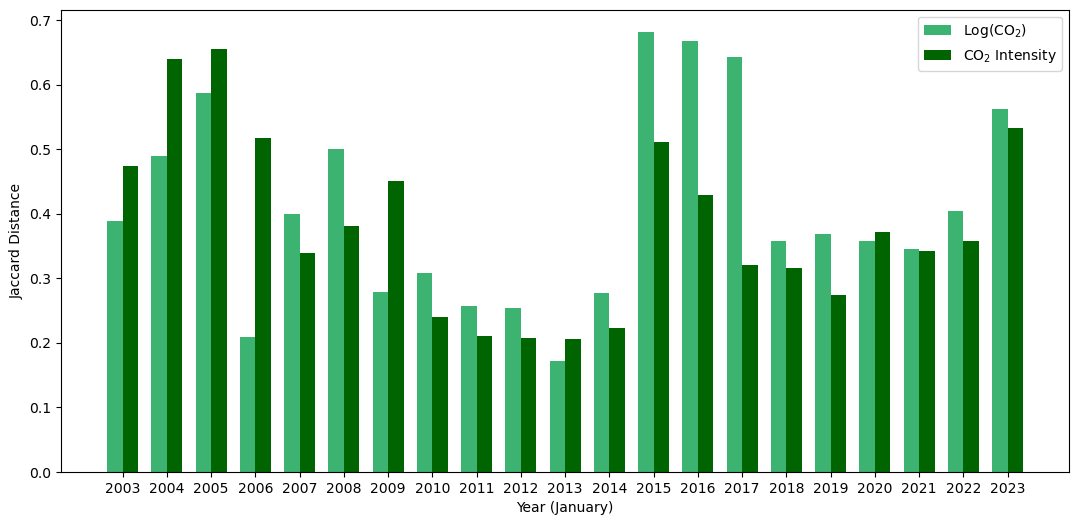

In [31]:
plt.figure(figsize=(13, 6))

categories = januarys
x = np.arange(len(categories))
bar_width = 0.35

plt.bar(x - bar_width/2, LogCO2_january_jaccards, bar_width, color = 'mediumseagreen', label='Log(CO$_2$)')
plt.bar(x + bar_width/2, CO2Intensity_january_jaccards, bar_width, color = 'darkgreen', label='CO$_2$ Intensity')

plt.xlabel('Year (January)')
plt.ylabel('Jaccard Distance')
# plt.title('Jaccard Distances (Dissimilarities) of Each January\'s Long-Short Portfolio With the Previous January\'s Portfolio')
plt.xticks(x, categories)
plt.legend()

plt.savefig('JaccardDistances.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Portfolio Composition

In [32]:
def unique_value_counts(df):
    results = {}
    for col in df.columns:
        value_counts = df[col].value_counts()
        results[col] = value_counts
    return pd.DataFrame(results)

## Log(CO$_2$) GMB Portfolio Composition

In [33]:
# Use the sectors represented in each monthyear's portfolio (an output of our create_FF_factor() function)
# Filter for only January portfolios
LogCO2_sectors_january = LogCO2_sectors[['200201', '200301', '200401', '200501', '200601', '200701', '200801', '200901', '201001',
                                         '201101', '201201', '201301', '201401', '201501', '201601', '201701', '201801', '201901', '202001',
                                         '202101', '202201', '202301']]

In [34]:
LogCO2_sector_counts = unique_value_counts(LogCO2_sectors_january)
LogCO2_sector_counts.columns = [col[:-2] for col in LogCO2_sector_counts.columns]

# Renaming sectors to be consistent with our report
LogCO2_sector_counts = LogCO2_sector_counts.rename(index={'AccomFood': 'Accommodation', 
                                                          'FinanceIns': 'Finance',
                                                          'OilGas': 'Oil & Gas',
                                                          'RealEstate': 'Real Estate',
                                                          'TransportWarehouse': 'Transportation',})
print(LogCO2_sector_counts)

                2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  \
Accommodation    2.0   2.0   1.0   1.0   1.0   1.0   NaN   1.0   1.0   1.0   
Construction     1.0   1.0   1.0   NaN   NaN   1.0   NaN   NaN   NaN   NaN   
Finance          6.0   6.0   6.0  14.0  14.0  14.0  20.0  22.0  19.0  21.0   
Information      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0   1.0   
Manufacturing    5.0   4.0   5.0  10.0   8.0   7.0   8.0   9.0  13.0  11.0   
Oil & Gas        3.0   2.0   4.0   3.0   2.0   2.0   2.0   4.0   4.0   3.0   
Real Estate      4.0   4.0  11.0   NaN   NaN   NaN   2.0   1.0   NaN   NaN   
Retail           1.0   NaN   1.0   1.0   1.0   NaN   1.0   1.0   1.0   1.0   
Services         NaN   NaN   NaN   1.0   2.0   2.0   2.0   3.0   2.0   4.0   
Transportation   NaN   NaN   NaN   NaN   NaN   NaN   3.0   4.0   5.0   5.0   
Utilities        6.0   9.0   9.0  12.0  14.0  17.0  18.0  19.0  19.0  21.0   
Wholesale        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

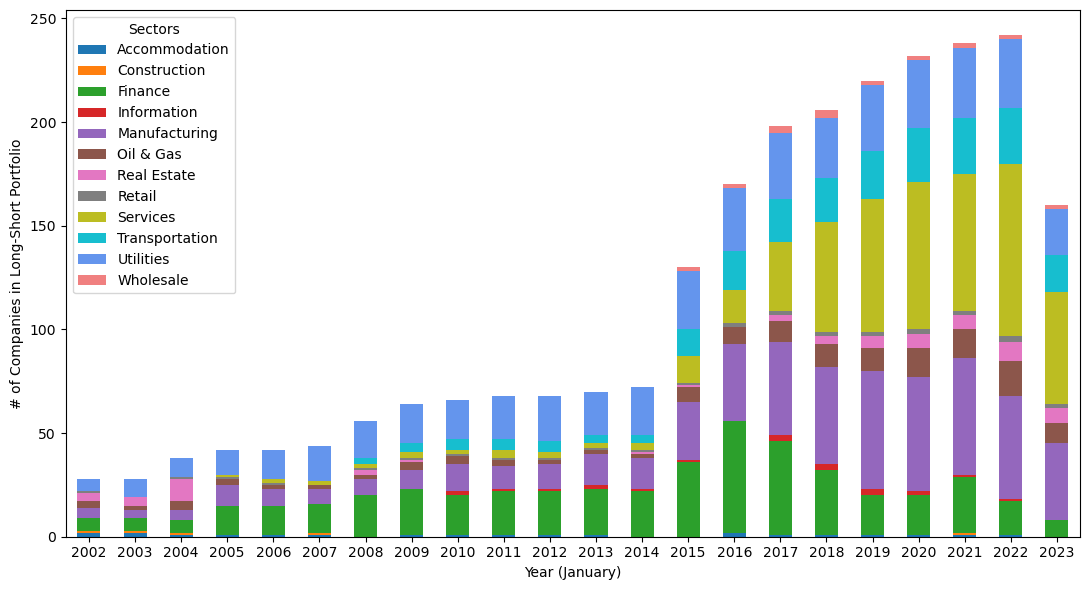

In [35]:
# Log(CO2) GMB Portfolio Composition Stacked Column Chart

colors = [
    'tab:blue',  # Accomodation & Food (middle)
    'tab:orange',  # Construction (middle)
    'tab:green',  # Finance & Insurance (green)
    'tab:red',  # Information (green)
    'tab:purple',  # Manufacturing (brown)
    'tab:brown',  # Oil & Gas (brown)
    'tab:pink',  # Real Estate (middle)
    'tab:gray',  # Retail (middle)
    'tab:olive',  # Services (green)
    'tab:cyan',  # Transportation (brown)
    'cornflowerblue', # Utilities (brown)
    'lightcoral' # Wholesale (brown)
]

LogCO2_sector_counts.T.plot.bar(stacked=True, figsize=(11, 6), color=colors)
plt.xlabel('Year (January)')
plt.ylabel('# of Companies in Long-Short Portfolio')
# plt.title('Log(CO$_2$) Long-Short Portfolio Composition by Sector')
plt.xticks(rotation=0)
plt.legend(title="Sectors")
plt.tight_layout()

plt.savefig('LogCO2_Portfolio_Sectors.pdf', dpi=300, bbox_inches='tight')

plt.show()

## CO$_2$ Intensity GMB Portfolio Composition

In [36]:
# Use the sectors represented in each monthyear's portfolio (an output of our create_FF_factor() function)
# Filter for only January portfolios
CO2Intensity_sectors_january = CO2Intensity_sectors[['200201', '200301', '200401', '200501', '200601', '200701', '200801', '200901', '201001',
                                         '201101', '201201', '201301', '201401', '201501', '201601', '201701', '201801', '201901', '202001',
                                         '202101', '202201', '202301']]

In [37]:
CO2Intensity_sector_counts = unique_value_counts(CO2Intensity_sectors_january)
CO2Intensity_sector_counts.columns = [col[:-2] for col in CO2Intensity_sector_counts.columns]

# Renaming sectors to be consistent with our report
CO2Intensity_sector_counts = CO2Intensity_sector_counts.rename(index={'AccomFood': 'Accommodation', 
                                                          'FinanceIns': 'Finance',
                                                          'OilGas': 'Oil & Gas',
                                                          'RealEstate': 'Real Estate',
                                                          'TransportWarehouse': 'Transportation',})

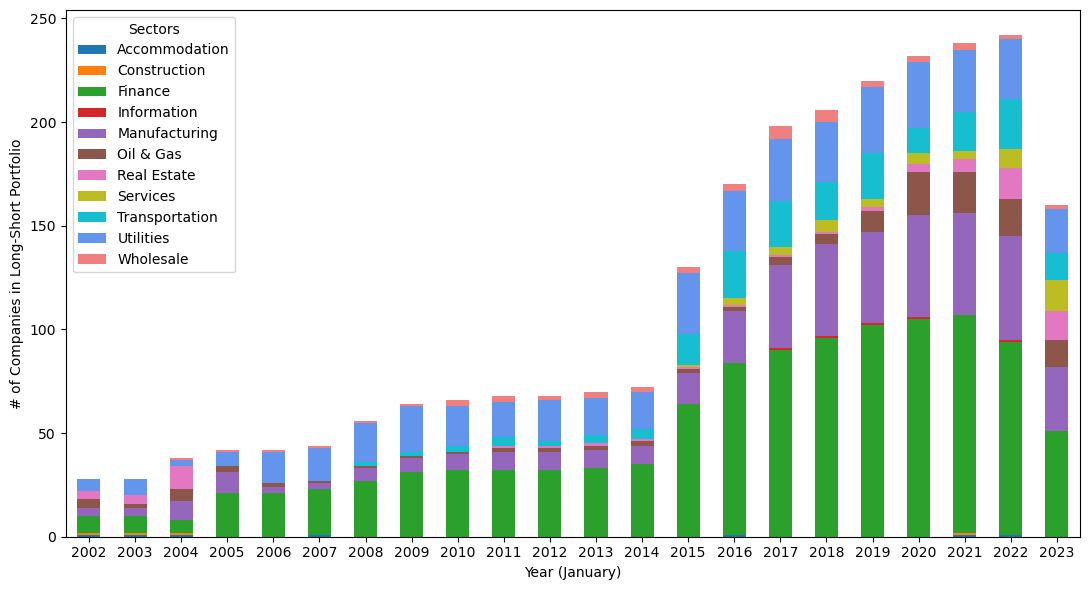

In [38]:
# CO2 Intensity GMB Portfolio Composition Stacked Column Chart

colors2 = [
    'tab:blue',  # Accomodation & Food (middle)
    'tab:orange',  # Construction (middle)
    'tab:green',  # Finance & Insurance (green)
    'tab:red',  # Information (green)
    'tab:purple',  # Manufacturing (brown)
    'tab:brown',  # Oil & Gas (brown)
    'tab:pink',  # Real Estate (middle)
    'tab:olive',  # Services (green)
    'tab:cyan',  # Transportation (brown)
    'cornflowerblue', # Utilities (brown)
    'lightcoral' # Wholesale (brown)
]

CO2Intensity_sector_counts.T.plot.bar(stacked=True, figsize=(11, 6), color=colors2)
plt.xlabel('Year (January)')
plt.ylabel('# of Companies in Long-Short Portfolio')
# plt.title('CO$_2$ Intensity Long-Short Portfolio Composition by Sector')
plt.xticks(rotation=0)
plt.legend(title="Sectors")
plt.tight_layout()

plt.savefig('CO2Intensity_Portfolio_Sectors.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Removing GMB Portfolio Stocks from Dataset (+ saving files for robustness checks)

In [39]:
factordata_copy = factordata.copy()

# Removing Log(CO2) GMB portfolio stocks first
columns_to_compare = ['monthyear', 'cusip']
# Create a boolean mask indicating rows in factordata_copy that match LogCO2_portfolio in the specified columns
mask = factordata_copy[columns_to_compare].apply(tuple, axis=1).isin(LogCO2_portfolio[columns_to_compare].apply(tuple, axis=1))
    
# Invert the mask and filter factordata_copy to keep only the rows that do not match
factordata_minus_LogCO2 = factordata_copy[~mask]
    
print(factordata_minus_LogCO2)

           cusip  year  Month monthyear  Mkt-RF   SMB   HML    RF   RMW   CMA  \
0       46603210  2015      1    201501   -3.11 -0.92 -3.59  0.00  1.61 -1.65   
1       46603210  2015      2    201502    6.13  0.32 -1.86  0.00 -1.12 -1.82   
2       46603210  2015      3    201503   -1.12  3.07 -0.38  0.00  0.09 -0.52   
3       46603210  2015      4    201504    0.59 -3.09  1.82  0.00  0.06 -0.61   
4       46603210  2015      5    201505    1.36  0.84 -1.15  0.00 -1.80 -0.75   
...          ...   ...    ...       ...     ...   ...   ...   ...   ...   ...   
295824  12503M10  2023      8    202308   -2.39 -3.68 -1.08  0.45  3.42 -2.37   
295825  12503M10  2023      9    202309   -5.24 -1.79  1.45  0.43  1.85 -0.84   
295826  12503M10  2023     10    202310   -3.18 -4.05  0.19  0.47  2.47 -0.67   
295827  12503M10  2023     11    202311    8.83 -0.11  1.66  0.44 -3.81 -0.99   
295828  12503M10  2023     12    202312    4.87  7.33  4.92  0.43 -3.04  1.30   

             RET  ExcessRet

In [40]:
print('Rows removed after LogCO2 mask =', len(factordata) - len(factordata_minus_LogCO2))
print('Number of stocks in LogCO2 portfolio =', len(LogCO2_portfolio))

Rows removed after LogCO2 mask = 29789
Number of stocks in LogCO2 portfolio = 29789


In [41]:
# Now removing remainign CO2 intensity GMB portfolio stocks

# Create a boolean mask indicating rows in factordata_minus_LogCO2 that match CO2Intensity_portfolio in the specified columns
mask_2 = factordata_minus_LogCO2[columns_to_compare].apply(tuple, axis=1).isin(CO2Intensity_portfolio[columns_to_compare].apply(tuple, axis=1))
    
# Invert the mask and filter factordata_minus_LogCO2 to keep only the rows that do not match
factordata_minus_portfolios = factordata_minus_LogCO2[~mask_2]
    
print(factordata_minus_portfolios)

           cusip  year  Month monthyear  Mkt-RF   SMB   HML    RF   RMW   CMA  \
0       46603210  2015      1    201501   -3.11 -0.92 -3.59  0.00  1.61 -1.65   
1       46603210  2015      2    201502    6.13  0.32 -1.86  0.00 -1.12 -1.82   
2       46603210  2015      3    201503   -1.12  3.07 -0.38  0.00  0.09 -0.52   
3       46603210  2015      4    201504    0.59 -3.09  1.82  0.00  0.06 -0.61   
4       46603210  2015      5    201505    1.36  0.84 -1.15  0.00 -1.80 -0.75   
...          ...   ...    ...       ...     ...   ...   ...   ...   ...   ...   
295824  12503M10  2023      8    202308   -2.39 -3.68 -1.08  0.45  3.42 -2.37   
295825  12503M10  2023      9    202309   -5.24 -1.79  1.45  0.43  1.85 -0.84   
295826  12503M10  2023     10    202310   -3.18 -4.05  0.19  0.47  2.47 -0.67   
295827  12503M10  2023     11    202311    8.83 -0.11  1.66  0.44 -3.81 -0.99   
295828  12503M10  2023     12    202312    4.87  7.33  4.92  0.43 -3.04  1.30   

             RET  ExcessRet

In [42]:
print('Rows removed after CO2 Intensity mask =', len(factordata_minus_LogCO2) - len(factordata_minus_portfolios))
print('Number of stocks in CO2 Intensity portfolio =', len(CO2Intensity_portfolio))
print('Implied number of stocks overlapping in the LogCO2 and CO2 Intensity portfolios =', len(CO2Intensity_portfolio) - (len(factordata_minus_LogCO2) - len(factordata_minus_portfolios)))
print('Percentage form of above =', (len(CO2Intensity_portfolio) - (len(factordata_minus_LogCO2) - len(factordata_minus_portfolios)))/len(CO2Intensity_portfolio))

Rows removed after CO2 Intensity mask = 18347
Number of stocks in CO2 Intensity portfolio = 29790
Implied number of stocks overlapping in the LogCO2 and CO2 Intensity portfolios = 11443
Percentage form of above = 0.38412218865391073


In [43]:
# Export datafile for future robustness check
factordata_minus_portfolios.to_csv('factordata_minus_portfolios.csv', index=False)